Ce notebook présente une implémentation pas à pas d'un réseau neurones en NumPy destiné à reconnaitre des chiffres manuscrits. Le réseau peut contenir un nombre arbitraire de couches et de neurones par couche. Les calculs sont entièrements vectorisés (implémentation adaptée de http://neuralnetworksanddeeplearning.com)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

Dans un premier temps chargeons les données [MNIST](http://yann.lecun.com/exdb/mnist/). Celles-ci sont des images de 28x28 pixels représentant des chiffres manuscrits et leur identification. Cette base de donnée provient du NIST. La représentation utilisée ici a été préparée pour être directement lue avec Python par le laboratoire de Machine Learning de l'université de Montreal: http://www.deeplearning.net/tutorial/gettingstarted.html

In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")

#Affiche le type et les dimensions des données
print(type(training_data), type(validation_data), type(test_data))
print(np.shape(training_data[0]), np.shape(training_data[1]),
     np.shape(validation_data[0]), np.shape(validation_data[1]),
     np.shape(test_data[0]), np.shape(test_data[1]))

<class 'tuple'> <class 'tuple'> <class 'tuple'>
(50000, 784) (50000,) (10000, 784) (10000,) (10000, 784) (10000,)


La lecture de ce fichier renvoie trois tuples ``(x,y)``. ``x`` est une matrice 50 000x784 (ou 10 000x784) où 50 000 (ou 10 000) est le nombre d'images et 784 est le vecteur correspondant à l'image (28x28 = 784 pixels). ``y`` est un vecteur de 50 000 lignes (ou 10 000 lignes) correspondant au chiffre affiché dans chaque image.

Re-organisons les données pour qu'elles soient plus facilement manipulables par la suite. Le tableau ``training_data_x`` sera un tableau 50 000x784. Chacune des 50 000 cases de ce tableau contient le vecteur image``x`` à 784 composantes. ``training_data_y`` est un vecteur à 10 composantes contenant le vecteur correspondant au chiffre affiché dans l'image.

De façon analogue, ``validation_data_x`` et ``test_data_x`` contiennent 10 000 vecteurs ``x`` correspondant au vecteur image à 784 composante. ``validation_data_y`` et ``test_data_y`` seront deux tableaux de 10 000 lignes contenant l'entier correspondant à l'image.

__Aparté__:  NumPy encode les vecteurs en ligne plutôt qu'en colonnes. Ainsi, mathématiquement, un vecteur de 3 composantes s'écrit comme une matrice de 3x1 dimensions en NumPy, et non un vecteur de longueur 3.

Exemple: ``a = np.array([0,1,2])`` est un vecteur de dimension (3,) et s'affiche ``[0,1,2]``. Créons une matrice en ajoutant une dimension à ce vecteur avec ``b = a[:,np.newaxis]``. Les dimensions de cette matrice deviennent (3,1) et celui s'affiche
```
[[0]
 [1]
 [2]]
 ```
 
Ainsi, le nombre 3 qui désignait une colonne dans le vecteur, désigne à présent une ligne dans la matrice. Si cela n'a que peu d'importance si l'on considère ces indices comme des dimensions indépendantes, cela peut prêter à confusion en algèbre linéaire où les indices ont une représentation bien précise en terme de lignes/colonnes.
En résumé, représenter rigoureusement les vecteurs en NumPy necessite d'introduire une dimension supplémentaire ce qui alourdit le code. Dans la suite, nous nous conformons à la notation NumPy plutôt que la notation mathématique exacte. Cela implique que tous les vecteurs et tenseurs sont en fait transposés. De plus les produis tensoriels sont inversés: A.B s'écrira np.dot(B,A).

In [3]:
N_dim = training_data[0].shape[1]   #Dimension du vecteur image

training_data_x  = np.array(training_data[0])
training_data_y = np.eye(10)[training_data[1]]

validation_data_x  = np.array(validation_data[0])
validation_data_y = validation_data[1]

test_data_x  = np.array(test_data[0])
test_data_y = test_data[1]

Le chiffre est 5
L'image est:


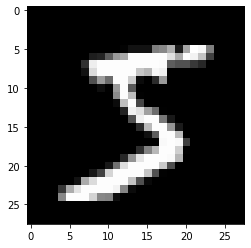

In [4]:
print("Le chiffre est",np.argmax(training_data_y[0]))
print("L'image est:")
plt.imshow(training_data_x[0,:].reshape(28,28), cmap='gray');

Nous allons définir une liste de nombres `sizes` = [a,b,c...,N] décrivant notre réseau de neurones. a est le nombre de neurones dans la couche d'entrée et N est le nombre de neurones dans la couche de sortie. b,c,... sont les nombres de neurons dans les couches cachées. Par exemple [784, 30, 10] est un réseau à 3 couches présentant 784 neurones d'entrée (les pixels de l'image), 10 neurones de sortie (le vecteur représentant le chiffre) et une couche cachée de 30 neurones.

Dans un réseau de neurone, l'activation des neurones dans un couche $l$ dépend de l'activation de tous les neurons de la couche $l-1$ selon:

$$z^{l}_j = \sum_k w^{l}_{jk} a^{l-1}_k + b^l_j $$

$$a^{l}_j = \sigma\left( z^{l}_k \right)$$

Soit, de façon tensorielle:

$$ z^l = w^l a^{l-1} + b^l $$

$$ a^l = \sigma( z^l) $$

$w_{jk}$ et $b_j$ sont les poids et biais des neurones de la couche $l$ et $\sigma$ est la fonction d'activation (choisie comme une fonction sigmoïde).

Ci-dessous, nous initialisons deux listes contenant (pour chaque couche de neurones) les tenseurs de poids $w_{jk}$ et les vecteurs $b_j$ avec des nombres aléatoire gaussiens (centrés sur 0 et d'écart-type unité). Conformément aux équations précédentes, chaque vecteur de biais présente autant de dimensions/lignes que de neurones dans la couche concernée, et chaque tenseur de poids présente autant de lignes que de neurones dans la couches en cours et autant de colonnes que dans la couche précédente.

In [5]:
sizes = [N_dim, 30, 10]

num_layers = len(sizes)

biases = [np.random.randn(x) for x in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[1:], sizes[:-1])]

for i in np.arange(len(weights)):
    print("Les dimensions du tenseur wjk et du vecteur bj dans la couche", i+1,
          "sont",np.shape(weights[i])," et ", np.shape(biases[i]))

Les dimensions du tenseur wjk et du vecteur bj dans la couche 1 sont (784, 30)  et  (30,)
Les dimensions du tenseur wjk et du vecteur bj dans la couche 2 sont (30, 10)  et  (10,)


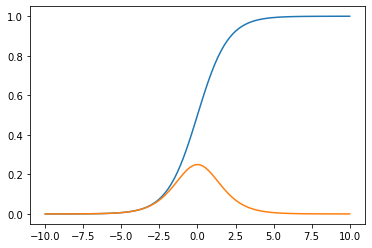

In [6]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

i = np.linspace(-10, 10, 100)
plt.plot(i, sigmoid(i), i, sigmoid_prime(i));

In [7]:
'''
Cette fonction calcule la réponse du réseau de neurones pour une image d'entrée "a".
Elle renvoie un vecteur correspondant au chiffre attendu.
'''
def feedforward(a):
    global biases, weights
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(a, w)+b)
    return a

# Est-ce que le réseau arrive à reconnaitre le premier chiffre ?
calc_vector = feedforward(training_data_x[0])
real_vector = training_data_y[0]
print("Chiffre identifié :", np.argmax(calc_vector), "; Chiffre réel:", np.argmax(real_vector))


Chiffre identifié : 5 ; Chiffre réel: 5


In [14]:
def backprop(x, y):
    """Renvoie un tuple ``(nabla_b, nabla_w, err)`` représentant le
    le gradient de la fonction de cout C sommé sur toutes les données.
    ``nabla_b`` et ``nabla_w`` sont des listes de tableaux numpy 
    analogues à ``biases`` and ``weights``."""
    global weights, biases
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    # feedforward
    activation = x
    activations = [x] # liste contenant toutes les activations par couche
    zs = [] # liste contenant les z par couche
    for b, w in zip(biases, weights):
        z = np.dot(activation,w)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Calcul des erreurs de la dernière couche
    #err = ((activations[-1] - y)**2).sum(axis=(0,1))
    
    delta = (activations[-1] - y) * sigmoid_prime(zs[-1])

    nabla_b[-1] = delta.sum(axis=0)
    nabla_w[-1] = np.dot(activations[-2].transpose(), delta)
    
    # Retro-propagation
    # Graduation negative pour réculer dans le réseau.
    for l in range(2, num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(delta, weights[-l+1].transpose()) * sp
        nabla_b[-l] = delta.sum(axis=0)
        nabla_w[-l] = np.dot(activations[-l-1].transpose(), delta)

    return (nabla_b, nabla_w)

def update_weights_biases(x, y, eta):
    """ Ajuste les poids et biais par la méthode du gradient
    stochastique dans un mini-lot. ``eta`` est la vitesse d
    aprentissage (poids affecté au gradient)"""
    global weights, biases
    mb_size = x.shape[0]

    nabla_b, nabla_w = backprop(x, y)

    weights = [w-(eta/mb_size)*nw for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/mb_size)*nb for b, nb in zip(biases, nabla_b)]

def train(train_data, epochs, mini_batch_size, eta, test_data=None):
    """Entraine le réseau de neurone par la méthode du gradient
    stochastique par mini-lots. Les données d'entrée sont les 
    les tableaux MxN_dim où M est le nombre de données expérimentales
    et N_dim est la dimension du vecteur image. Epochs est le nombre
    d'itération requises pour l'apprentissage. Mini_batch_size est le
    nombre de mini-lots. Eta est la vitesse d'aprentissage. Test_data
    permet d'évaluer la précision atteinte par le réseau en utilisant
    un jeu de données indépendant"""
    global weights, biases, rmse_train, accuracy_train
    
    (x, y) = train_data
    
    if test_data:
        n_test = len(test_data[1])
        rmse_train[0], accuracy_train[0], rmse_test[0], accuracy_test[0] = error_accuracy(x, y, test_data)
    else :
        rmse_train[0], accuracy_train[0] = error_accuracy(x, y, test_data)
         
    for j in range(epochs):
        s = np.arange(x.shape[0])
        np.random.shuffle(s)
        x_mb = np.split(x[s], mini_batch_size)
        y_mb = np.split(y[s], mini_batch_size)

        for xx, yy in zip(x_mb,y_mb):
            update_weights_biases(xx, yy, eta)
           
        

        if test_data:
            rmse_train[j+1], accuracy_train[j+1], rmse_test[j+1], accuracy_test[j+1] = error_accuracy(x, y, test_data)
            print("Epoch {} : Training error {:6.4f} (accuracy {:6.4f}%) ; Test error {:6.4f} (accuracy {:6.4f}%)"
                  .format(j+1, rmse_train[j], 100*accuracy_train[j+1], rmse_test[j+1], 100*accuracy_test[j+1]))
            
        else:
            rmse_train[j+1], accuracy_train[j+1] = error_accuracy(x, y, test_data)
            print("Epoch {} : Training error {:6.4f}  (accuracy {:6.3f}%)"
                  .format(j+1, rmse_train[j+1], 100*accuracy_train[j+1]))


def error_accuracy(x, y, test_data=None):
    # Calcule la réponse du réseau
    a = feedforward(x)
    # Evalue l'erreur totale
    error = ((a - y)**2).sum(axis=(0,1))
    # Combien de chiffre le réseau a-t-il reconnu
    result = np.argmax(a, axis=1)
    result = (result == np.argmax(y, axis=1)).sum()
    
    if test_data:
        (xt, yt) = test_data
        # Calcule la réponse du réseau
        at = feedforward(xt)
        # Evalue l'erreur totale
        yt = np.eye(10)[yt]
        error_t = ((at - yt)**2).sum(axis=(0,1))
        # Combien de chiffre le réseau a-t-il reconnu
        result_t = np.argmax(at, axis=1)
        result_t = (result_t == np.argmax(yt, axis=1)).sum()
        return error / a.shape[0], result / a.shape[0], error_t / at.shape[0], result_t / at.shape[0]
    
    else:
        return error / a.shape[0], result / a.shape[0]
    
            
def eval_accuracy(test_data_x, test_data_y):
    """Retourne le nombre de chiffres que le réseau a correctement reconnu
    dans un jeu de données indépendant de celui utilisé pour l'entrainement"""
    test_results = [(np.argmax(feedforward(x)), y) for (x, y) in zip(test_data_x, test_data_y)]
    return sum(int(x == y) for (x, y) in test_results)       

In [16]:
mini_batch_size = 100
epochs = 100
rate = 5.0

rmse_train = np.zeros(epochs+1)
accuracy_train = np.zeros(epochs+1)
rmse_test = np.zeros(epochs+1)
accuracy_test = np.zeros(epochs+1)

train((training_data_x, training_data_y), epochs, mini_batch_size, rate, test_data=(test_data_x, test_data_y))

Epoch 1 : Training error 0.2962 (accuracy 79.6660%) ; Test error 0.2872 (accuracy 79.3900%)
Epoch 2 : Training error 0.2867 (accuracy 80.1180%) ; Test error 0.2796 (accuracy 79.7700%)
Epoch 3 : Training error 0.2786 (accuracy 80.5040%) ; Test error 0.2737 (accuracy 80.0800%)
Epoch 4 : Training error 0.2723 (accuracy 80.8060%) ; Test error 0.2675 (accuracy 80.5000%)
Epoch 5 : Training error 0.2664 (accuracy 81.0820%) ; Test error 0.2625 (accuracy 80.6900%)
Epoch 6 : Training error 0.2610 (accuracy 81.3360%) ; Test error 0.2591 (accuracy 80.8800%)
Epoch 7 : Training error 0.2568 (accuracy 81.5920%) ; Test error 0.2550 (accuracy 81.2900%)
Epoch 8 : Training error 0.2524 (accuracy 81.8180%) ; Test error 0.2516 (accuracy 81.4400%)
Epoch 9 : Training error 0.2488 (accuracy 81.9900%) ; Test error 0.2482 (accuracy 81.6300%)
Epoch 10 : Training error 0.2452 (accuracy 82.1920%) ; Test error 0.2455 (accuracy 81.8600%)
Epoch 11 : Training error 0.2420 (accuracy 82.3620%) ; Test error 0.2427 (accur

Epoch 90 : Training error 0.0915 (accuracy 94.6220%) ; Test error 0.1107 (accuracy 93.3500%)
Epoch 91 : Training error 0.0912 (accuracy 94.6480%) ; Test error 0.1102 (accuracy 93.3900%)
Epoch 92 : Training error 0.0908 (accuracy 94.6440%) ; Test error 0.1100 (accuracy 93.4500%)
Epoch 93 : Training error 0.0905 (accuracy 94.7240%) ; Test error 0.1099 (accuracy 93.3800%)
Epoch 94 : Training error 0.0899 (accuracy 94.7140%) ; Test error 0.1094 (accuracy 93.4900%)
Epoch 95 : Training error 0.0896 (accuracy 94.7380%) ; Test error 0.1091 (accuracy 93.5400%)
Epoch 96 : Training error 0.0892 (accuracy 94.7840%) ; Test error 0.1093 (accuracy 93.4600%)
Epoch 97 : Training error 0.0889 (accuracy 94.7900%) ; Test error 0.1090 (accuracy 93.5300%)
Epoch 98 : Training error 0.0885 (accuracy 94.8100%) ; Test error 0.1090 (accuracy 93.4600%)
Epoch 99 : Training error 0.0883 (accuracy 94.8160%) ; Test error 0.1087 (accuracy 93.4400%)
Epoch 100 : Training error 0.0878 (accuracy 94.8600%) ; Test error 0.1

In [ ]:
plt.plot(accuracy_train, label='Training accuracy')
plt.plot(rmse_train, label='Training error')
plt.plot(accuracy_test, label='Testing accuracy')
plt.plot(rmse_test, label='Testing error')

plt.xlabel('epoch')
plt.legend()

with open('saved_weights', 'wb') as fw:
    pickle.dump(weights, fw)
with open('saved_biases', 'wb') as fb:
    pickle.dump(biases, fb)

In [ ]:
a = np.array([[1,2,3],[4,5,6]])
norm_linalg = np.linalg.norm(a)**2
norm_sum = (a*a).sum(axis=(0,1))
#norm_dot = (np.dot(a,a))
print(norm_linalg, norm_sum, norm_dot)
np.allclose(norm_linalg, norm_sum)